# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


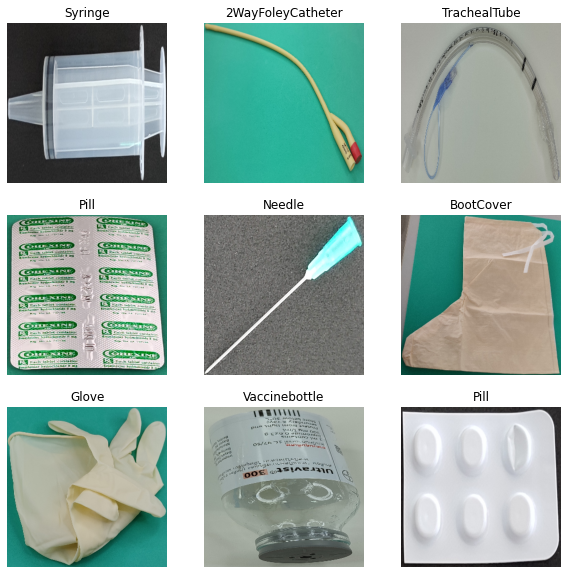

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
#DeepDense
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 41)                2665      
Total params: 22,075,977
Trainable params: 273,193
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

5


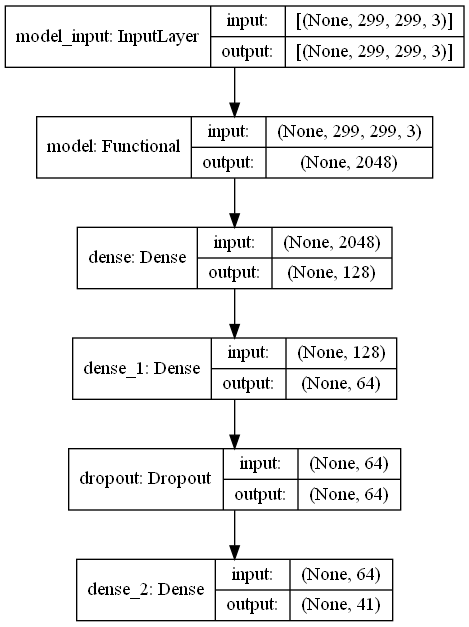

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
print(len(model.layers))
tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense128-64-NoClassImbalanced-NoAug-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 46s 328ms/step - loss: 2.2733 - accuracy: 0.4426 - val_loss: 1.3834 - val_accuracy: 0.6520
Epoch 2/2000
49/49 [==============================] - 9s 176ms/step - loss: 1.1418 - accuracy: 0.6863 - val_loss: 0.7737 - val_accuracy: 0.8072
Epoch 3/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.7086 - accuracy: 0.7861 - val_loss: 0.4998 - val_accuracy: 0.8603
Epoch 4/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.4713 - accuracy: 0.8646 - val_loss: 0.3794 - val_accuracy: 0.8797
Epoch 5/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.3397 - accuracy: 0.9063 - val_loss: 0.2908 - val_accuracy: 0.9172
Epoch 6/2000
49/49 [==============================] - 9s 176ms/step - loss: 0.2590 - accuracy: 0.9315 - val_loss: 0.2671 - val_accuracy: 0.9224
Epoch 7/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.2064 - accuracy: 0.9454 - val_loss: 0.2330 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

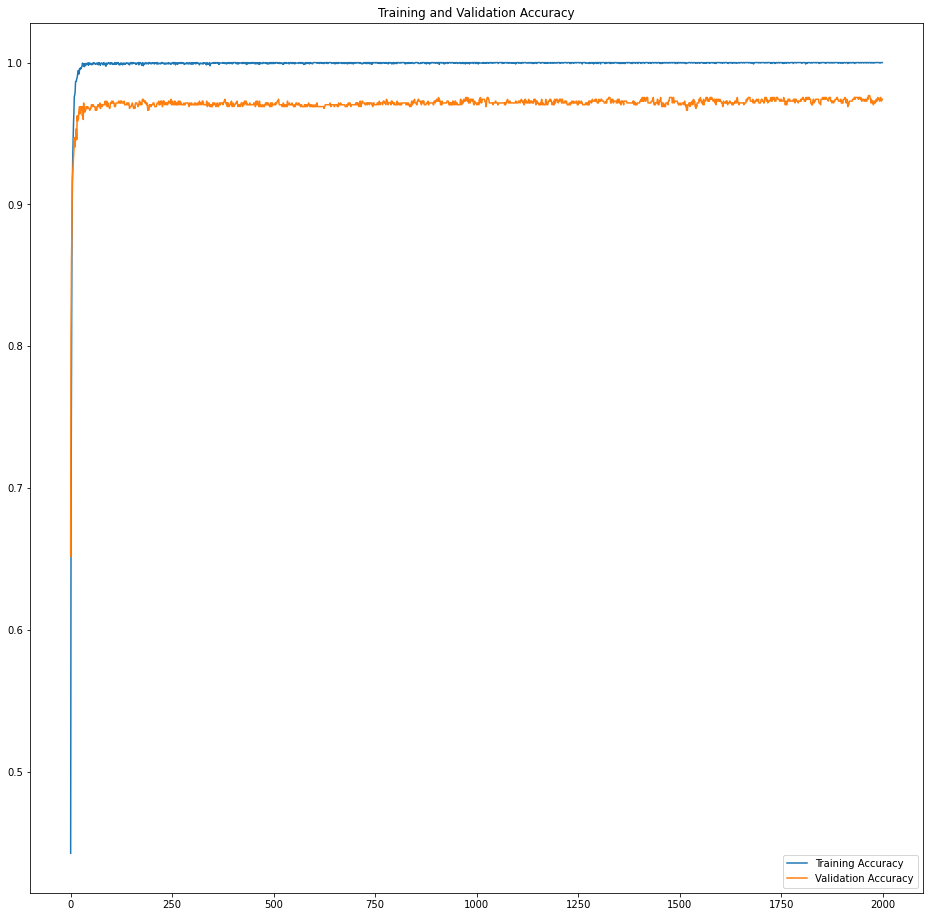

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


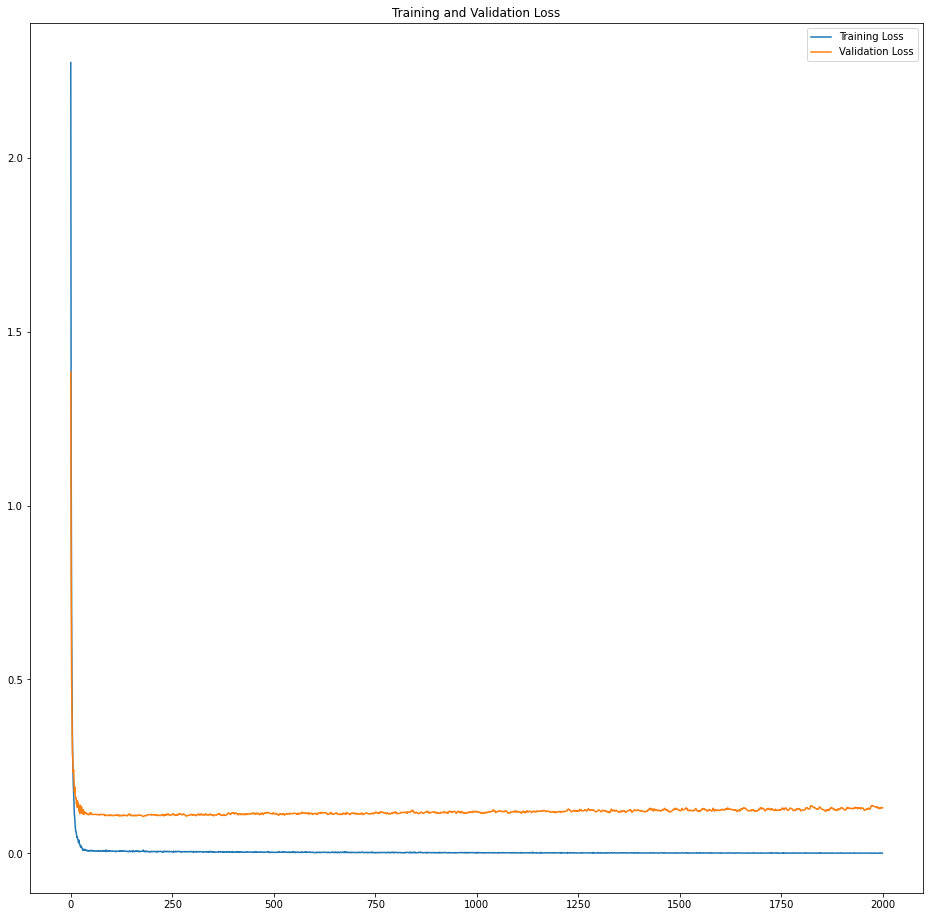

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 348ms/step - loss: 0.9363 - accuracy: 0.8032
test_indoor_ds_results:test loss, test acc: [0.9362500309944153, 0.8032330274581909]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 434ms/step - loss: 2.2250 - accuracy: 0.7178
test_outdoor_ds_results:test loss, test acc: [2.224958896636963, 0.7178344130516052]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 195ms/step - loss: 2.5288 - accuracy: 0.6451
test_belt_ds_results:test loss, test acc: [2.5287976264953613, 0.6450589299201965]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer_DeepDense-NoClassImbalanced-NoAug-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractor

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 132ms/step - loss: 1.9064 - accuracy: 0.6528
Epoch040 
 test_indoor_acc=0.7937569618225098 
 test_outdoor_acc=0.709554135799408 
 test_belt_acc=0.6527652144432068
35/35 [==============================] - 5s 131ms/step - loss: 1.9295 - accuracy: 0.6491
Epoch080 
 test_indoor_acc=0.7931995391845703 
 test_outdoor_acc=0.709554135799408 
 test_belt_acc=0.6491386890411377
35/35 [==============================] - 5s 130ms/step - loss: 1.9481 - accuracy: 0.6510
Epoch120 
 test_indoor_acc=0.7909699082374573 
 test_outdoor_acc=0.7070063948631287 
 test_belt_acc=0.6509519219398499
35/35 [==============================] - 5s 132ms/step - loss: 1.9706 - accuracy: 0.6510
Epoch160 
 test_indoor_acc=0.7931995391845703 
 test_outdoor_acc=0.7127388715744019 
 test_belt_acc=0.6509519219398499
35/35 [==============================] - 5s 132ms/step - loss: 1.9630 - accuracy: 0.6519
Epoch200 
 test_indoor_acc=0.7954292297363281 
 test_outdoor_acc=0.71464967727661

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

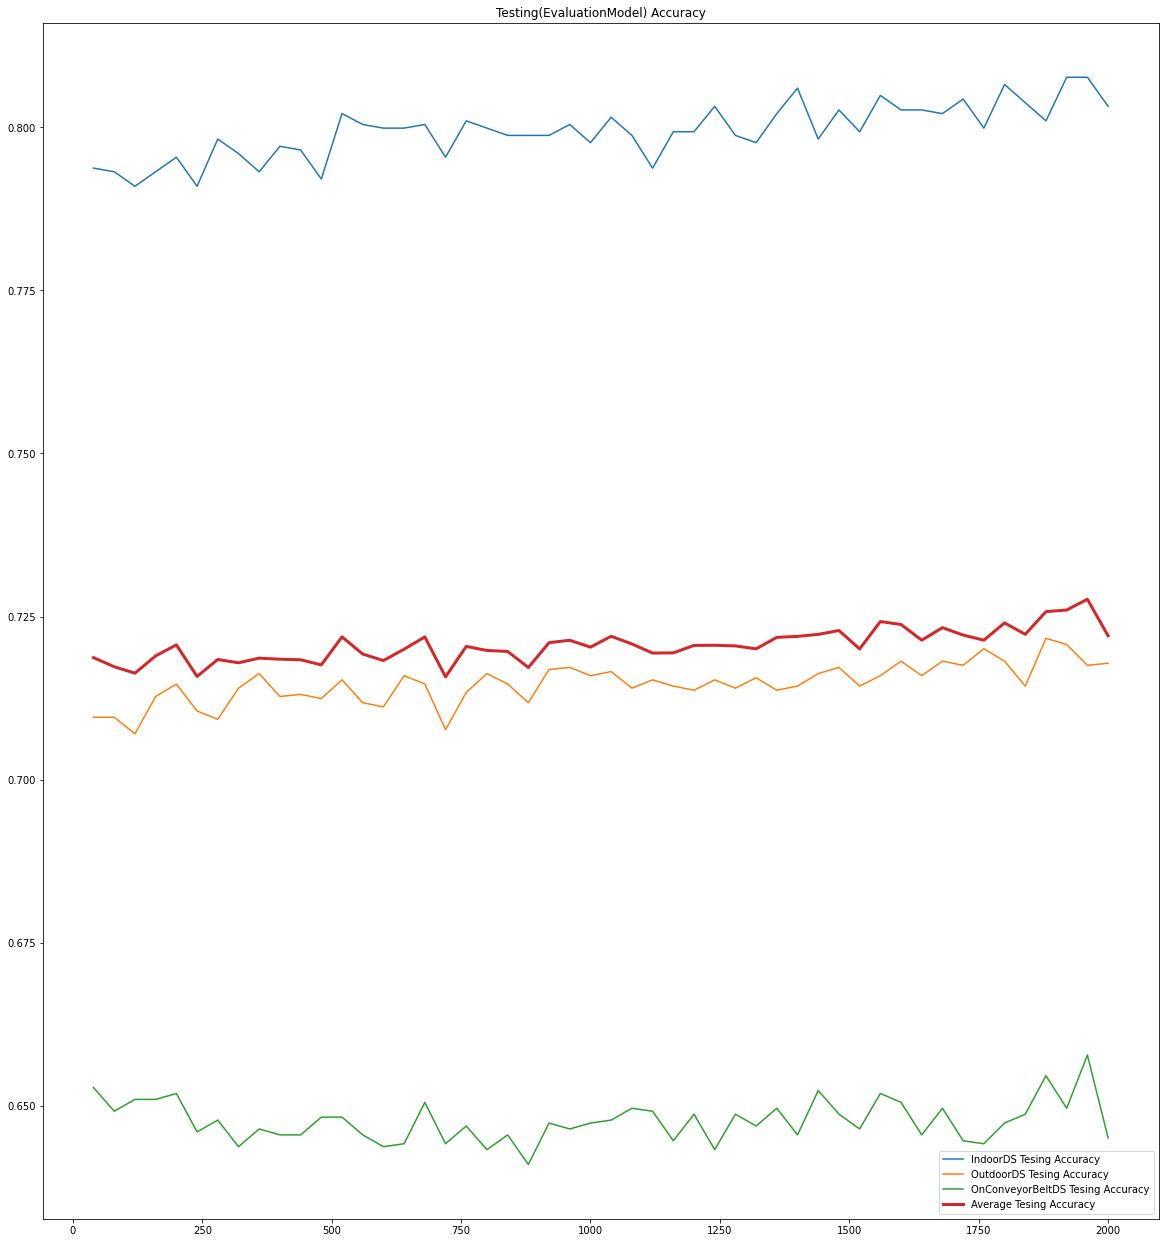

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7276532649993896
max index -> 48
The [Epoch] of max acc -> 1960


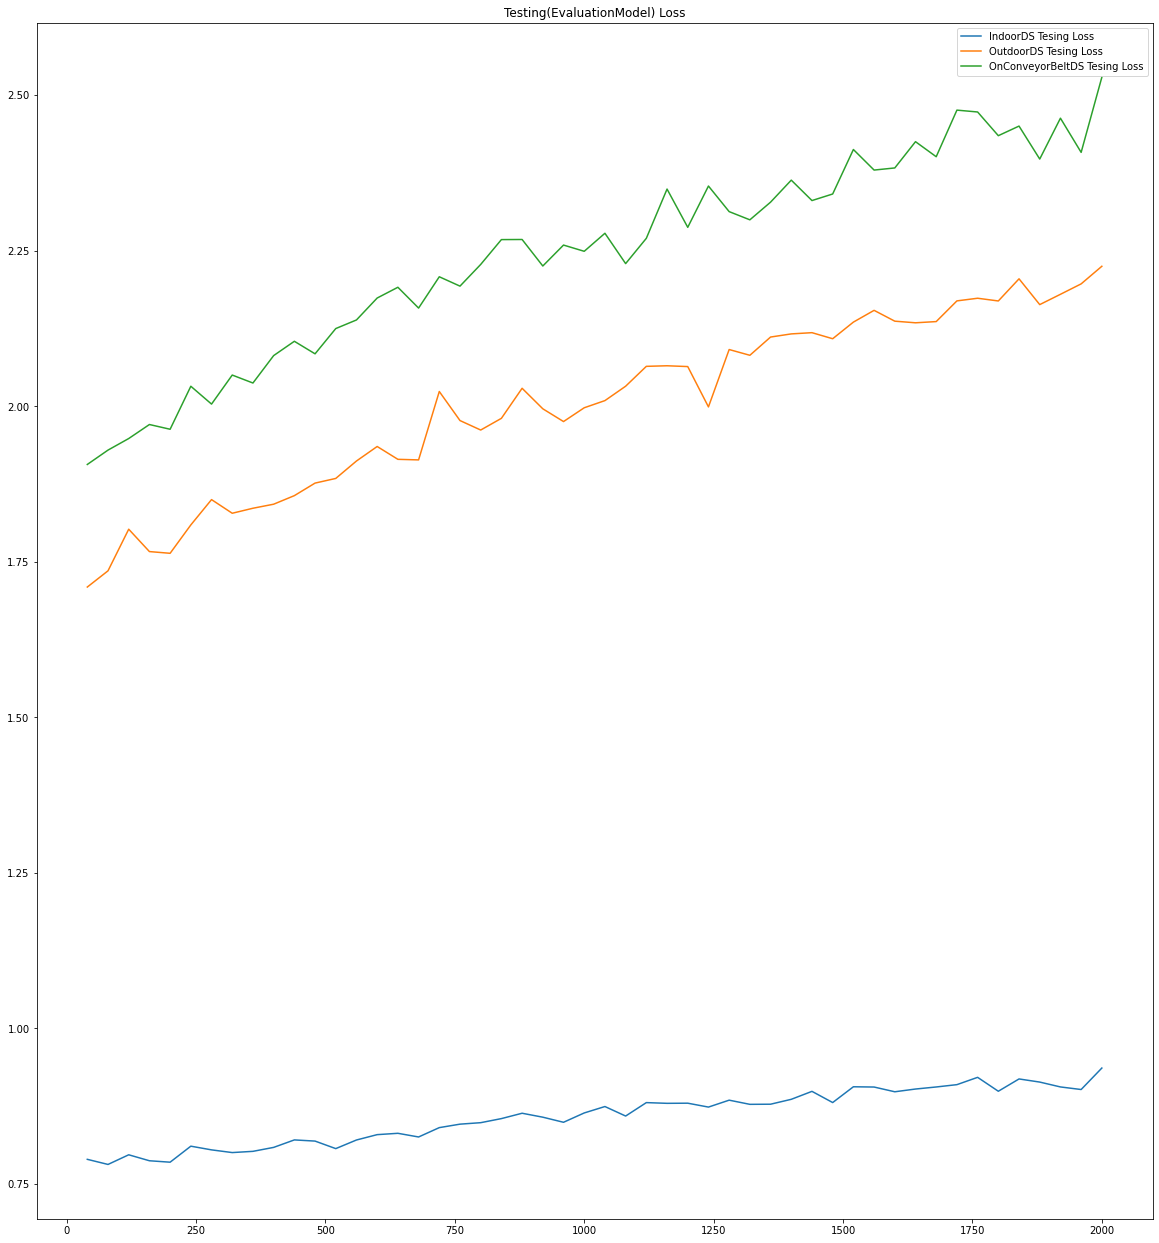

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.7937569618225098,
 0.7931995391845703,
 0.7909699082374573,
 0.7931995391845703,
 0.7954292297363281,
 0.7909699082374573,
 0.7982162833213806,
 0.7959865927696228,
 0.7931995391845703,
 0.7971014380455017,
 0.7965440154075623,
 0.7920847535133362,
 0.802118182182312,
 0.8004459142684937,
 0.7998884916305542,
 0.7998884916305542,
 0.8004459142684937,
 0.7954292297363281,
 0.8010033369064331,
 0.7998884916305542,
 0.7987737059593201,
 0.7987737059593201,
 0.7987737059593201,
 0.8004459142684937,
 0.7976588606834412,
 0.8015607595443726,
 0.7987737059593201,
 0.7937569618225098,
 0.7993311285972595,
 0.7993311285972595,
 0.8032330274581909,
 0.7987737059593201,
 0.7976588606834412,
 0.802118182182312,
 0.8060200810432434,
 0.7982162833213806,
 0.8026756048202515,
 0.7993311285972595,
 0.8049052357673645,
 0.8026756048202515,
 0.8026756048202515,
 0.802118182182312,
 0.804347813129425,
 0.7998884916305542,
 0.8065775036811829,
 0.8037903904914856,
 0.8010033369064331,
 0.80769228935241

In [38]:
test_outdoor_acc

[0.709554135799408,
 0.709554135799408,
 0.7070063948631287,
 0.7127388715744019,
 0.7146496772766113,
 0.7105095386505127,
 0.709235668182373,
 0.7140127420425415,
 0.7162420153617859,
 0.7127388715744019,
 0.7130573391914368,
 0.7124204039573669,
 0.7152866125106812,
 0.7117834687232971,
 0.7111464738845825,
 0.715923547744751,
 0.7146496772766113,
 0.7076433300971985,
 0.7133758068084717,
 0.7162420153617859,
 0.7146496772766113,
 0.7117834687232971,
 0.7168790102005005,
 0.7171974778175354,
 0.715923547744751,
 0.7165604829788208,
 0.7140127420425415,
 0.7152866125106812,
 0.7143312096595764,
 0.7136942744255066,
 0.7152866125106812,
 0.7140127420425415,
 0.7156050801277161,
 0.7136942744255066,
 0.7143312096595764,
 0.7162420153617859,
 0.7171974778175354,
 0.7143312096595764,
 0.715923547744751,
 0.7181528806686401,
 0.715923547744751,
 0.7181528806686401,
 0.7175159454345703,
 0.7200636863708496,
 0.7181528806686401,
 0.7143312096595764,
 0.7216560244560242,
 0.7207006216049194,

In [39]:
test_belt_acc

[0.6527652144432068,
 0.6491386890411377,
 0.6509519219398499,
 0.6509519219398499,
 0.6518585681915283,
 0.645965576171875,
 0.6477788090705872,
 0.6436989903450012,
 0.6464188694953918,
 0.6455122232437134,
 0.6455122232437134,
 0.648232102394104,
 0.648232102394104,
 0.6455122232437134,
 0.6436989903450012,
 0.6441522836685181,
 0.650498628616333,
 0.6441522836685181,
 0.6468721628189087,
 0.6432456970214844,
 0.6455122232437134,
 0.6409791707992554,
 0.6473254561424255,
 0.6464188694953918,
 0.6473254561424255,
 0.6477788090705872,
 0.6495920419692993,
 0.6491386890411377,
 0.6446056365966797,
 0.6486853957176208,
 0.6432456970214844,
 0.6486853957176208,
 0.6468721628189087,
 0.6495920419692993,
 0.6455122232437134,
 0.6523118615150452,
 0.6486853957176208,
 0.6464188694953918,
 0.6518585681915283,
 0.650498628616333,
 0.6455122232437134,
 0.6495920419692993,
 0.6446056365966797,
 0.6441522836685181,
 0.6473254561424255,
 0.6486853957176208,
 0.654578447341919,
 0.6495920419692993

In [40]:
test_indoor_loss

[0.7895190119743347,
 0.7813092470169067,
 0.7968164682388306,
 0.7872289419174194,
 0.7849228382110596,
 0.8106583952903748,
 0.8047255277633667,
 0.8003870248794556,
 0.8023574948310852,
 0.8087119460105896,
 0.8207229971885681,
 0.8188483119010925,
 0.8067448735237122,
 0.8205989599227905,
 0.8292044997215271,
 0.8313592076301575,
 0.8254475593566895,
 0.8404885530471802,
 0.8460592031478882,
 0.848427951335907,
 0.854985237121582,
 0.8635977506637573,
 0.8572602868080139,
 0.8490728735923767,
 0.8640625476837158,
 0.8743851780891418,
 0.8591001033782959,
 0.8806923031806946,
 0.8795374631881714,
 0.8797548413276672,
 0.8735034465789795,
 0.8846163153648376,
 0.8779096007347107,
 0.8781242370605469,
 0.8859907388687134,
 0.8987711071968079,
 0.8807861804962158,
 0.9061486124992371,
 0.9057217240333557,
 0.8981086015701294,
 0.9025158882141113,
 0.905815064907074,
 0.9095600247383118,
 0.9213017821311951,
 0.8989604115486145,
 0.9187204241752625,
 0.9137011170387268,
 0.9058718681335

In [41]:
test_outdoor_loss

[1.7093623876571655,
 1.7354542016983032,
 1.8023366928100586,
 1.7663886547088623,
 1.7636140584945679,
 1.8092132806777954,
 1.8499126434326172,
 1.8279850482940674,
 1.8360304832458496,
 1.8425202369689941,
 1.856292963027954,
 1.876454472541809,
 1.883945345878601,
 1.9119539260864258,
 1.9352874755859375,
 1.914662480354309,
 1.9137386083602905,
 2.023676633834839,
 1.9769724607467651,
 1.9617403745651245,
 1.9805541038513184,
 2.028843879699707,
 1.9958722591400146,
 1.9753656387329102,
 1.997531533241272,
 2.0090434551239014,
 2.0321757793426514,
 2.064119815826416,
 2.065037727355957,
 2.0637426376342773,
 1.998924732208252,
 2.0911290645599365,
 2.081878423690796,
 2.111210584640503,
 2.116260290145874,
 2.1182303428649902,
 2.1084933280944824,
 2.1352083683013916,
 2.15411114692688,
 2.1367132663726807,
 2.1341116428375244,
 2.136059284210205,
 2.1693179607391357,
 2.173576593399048,
 2.169193744659424,
 2.2047951221466064,
 2.1633400917053223,
 2.1799144744873047,
 2.1966667

In [42]:
test_belt_loss

[1.9063962697982788,
 1.9294934272766113,
 1.9480761289596558,
 1.9706103801727295,
 1.962989330291748,
 2.0321099758148193,
 2.0034453868865967,
 2.0501034259796143,
 2.037313461303711,
 2.081387996673584,
 2.1043906211853027,
 2.0842294692993164,
 2.1248438358306885,
 2.138667345046997,
 2.173924684524536,
 2.191209077835083,
 2.1577718257904053,
 2.20808744430542,
 2.1930408477783203,
 2.2279114723205566,
 2.267828941345215,
 2.2680118083953857,
 2.225400447845459,
 2.2590420246124268,
 2.2490272521972656,
 2.2780001163482666,
 2.229252338409424,
 2.26991605758667,
 2.349040985107422,
 2.28755521774292,
 2.3539297580718994,
 2.312803268432617,
 2.2996201515197754,
 2.3280224800109863,
 2.363406181335449,
 2.330590009689331,
 2.3411386013031006,
 2.4126362800598145,
 2.3795955181121826,
 2.3830063343048096,
 2.4252302646636963,
 2.401050329208374,
 2.4759347438812256,
 2.4729530811309814,
 2.4348597526550293,
 2.4502906799316406,
 2.397289514541626,
 2.4629931449890137,
 2.4080412387

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1960-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [4]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5152
FP=1988
acc=0.7215686274509804
all check = 7140


In [5]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 60.3448275862069%
2WayConnectorforFoley acc = 83.6734693877551%
2WayFoleyCatheter acc = 49.25373134328358%
3WayConnectorforFoley acc = 88.03418803418803%
3Waystopcock acc = 95.4954954954955%
AlcoholBottle acc = 88.125%
AlcoholPad acc = 34.12698412698413%
BootCover acc = 66.86746987951807%
CottonBall acc = 73.05389221556887%
CottonSwap acc = 79.02097902097903%
Dilator acc = 76.06837606837607%
DisposableInfusionSet acc = 43.36283185840708%
ExtensionTube acc = 26.82926829268293%
FaceShield acc = 54.32098765432099%
FrontLoadSyringe acc = 42.47787610619469%
GauzePad acc = 52.27272727272727%
Glove acc = 81.25%
GuideWire acc = 29.464285714285715%
LiquidBottle acc = 56.10687022900763%
Mask acc = 92.98701298701299%
NGTube acc = 38.064516129032256%
NasalCannula acc = 70.79646017699115%
Needle acc = 77.5%
OxygenMask acc = 96.99248120300751%
PPESuit acc = 91.93548387096774%
PharmaceuticalProduct acc = 65.65420560747664%
Pill acc = 96.9187675070028%
PillBottle acc = 67.4

In [6]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 70,   0,   0, ...,   0,   1,   0],
       [  1, 123,   0, ...,   0,   0,   1],
       [  0,   0,  66, ...,   0,   1,  13],
       ...,
       [  0,   0,   0, ...,  72,   1,   1],
       [  0,   0,   0, ...,   0, 181,   0],
       [  0,   0,   0, ...,   0,   0,  68]], dtype=int64)

In [7]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[60.34482759,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.68027211, 83.67346939,  0.        , ...,  0.        ,
         0.        ,  0.68027211],
       [ 0.        ,  0.        , 49.25373134, ...,  0.        ,
         0.74626866,  9.70149254],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 60.        ,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        84.97652582,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 59.64912281]])

<AxesSubplot:>

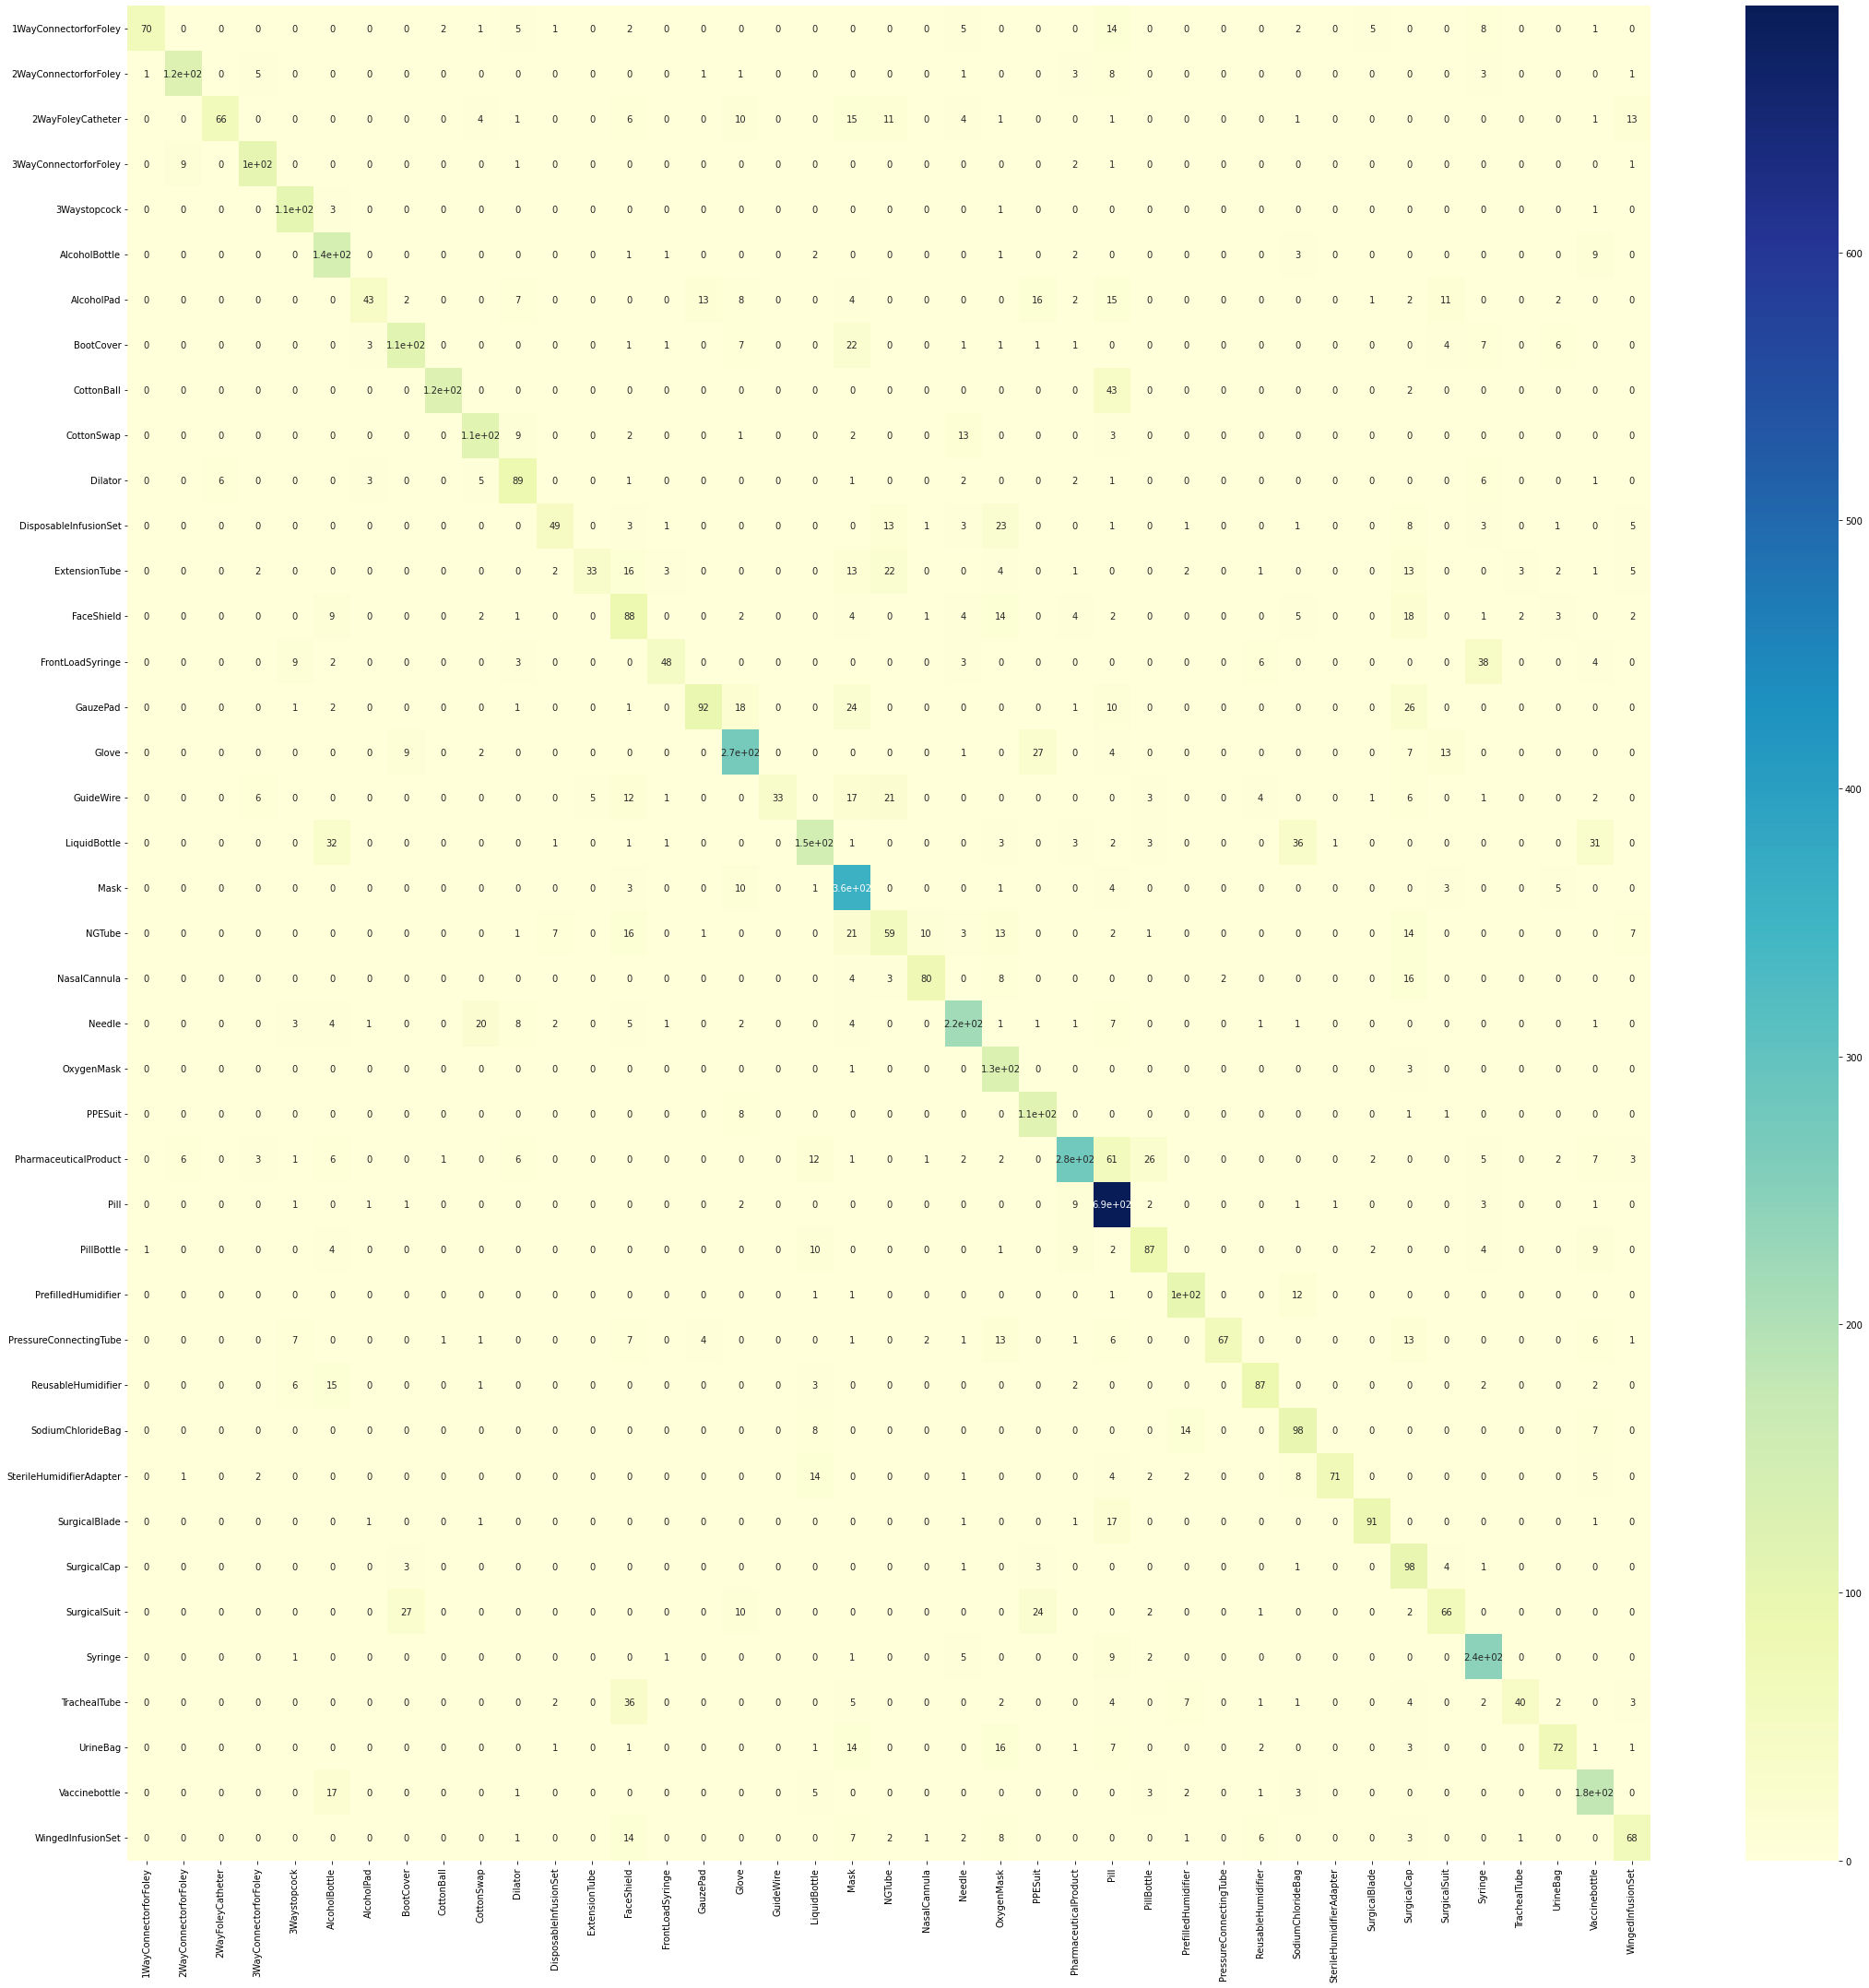

In [9]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

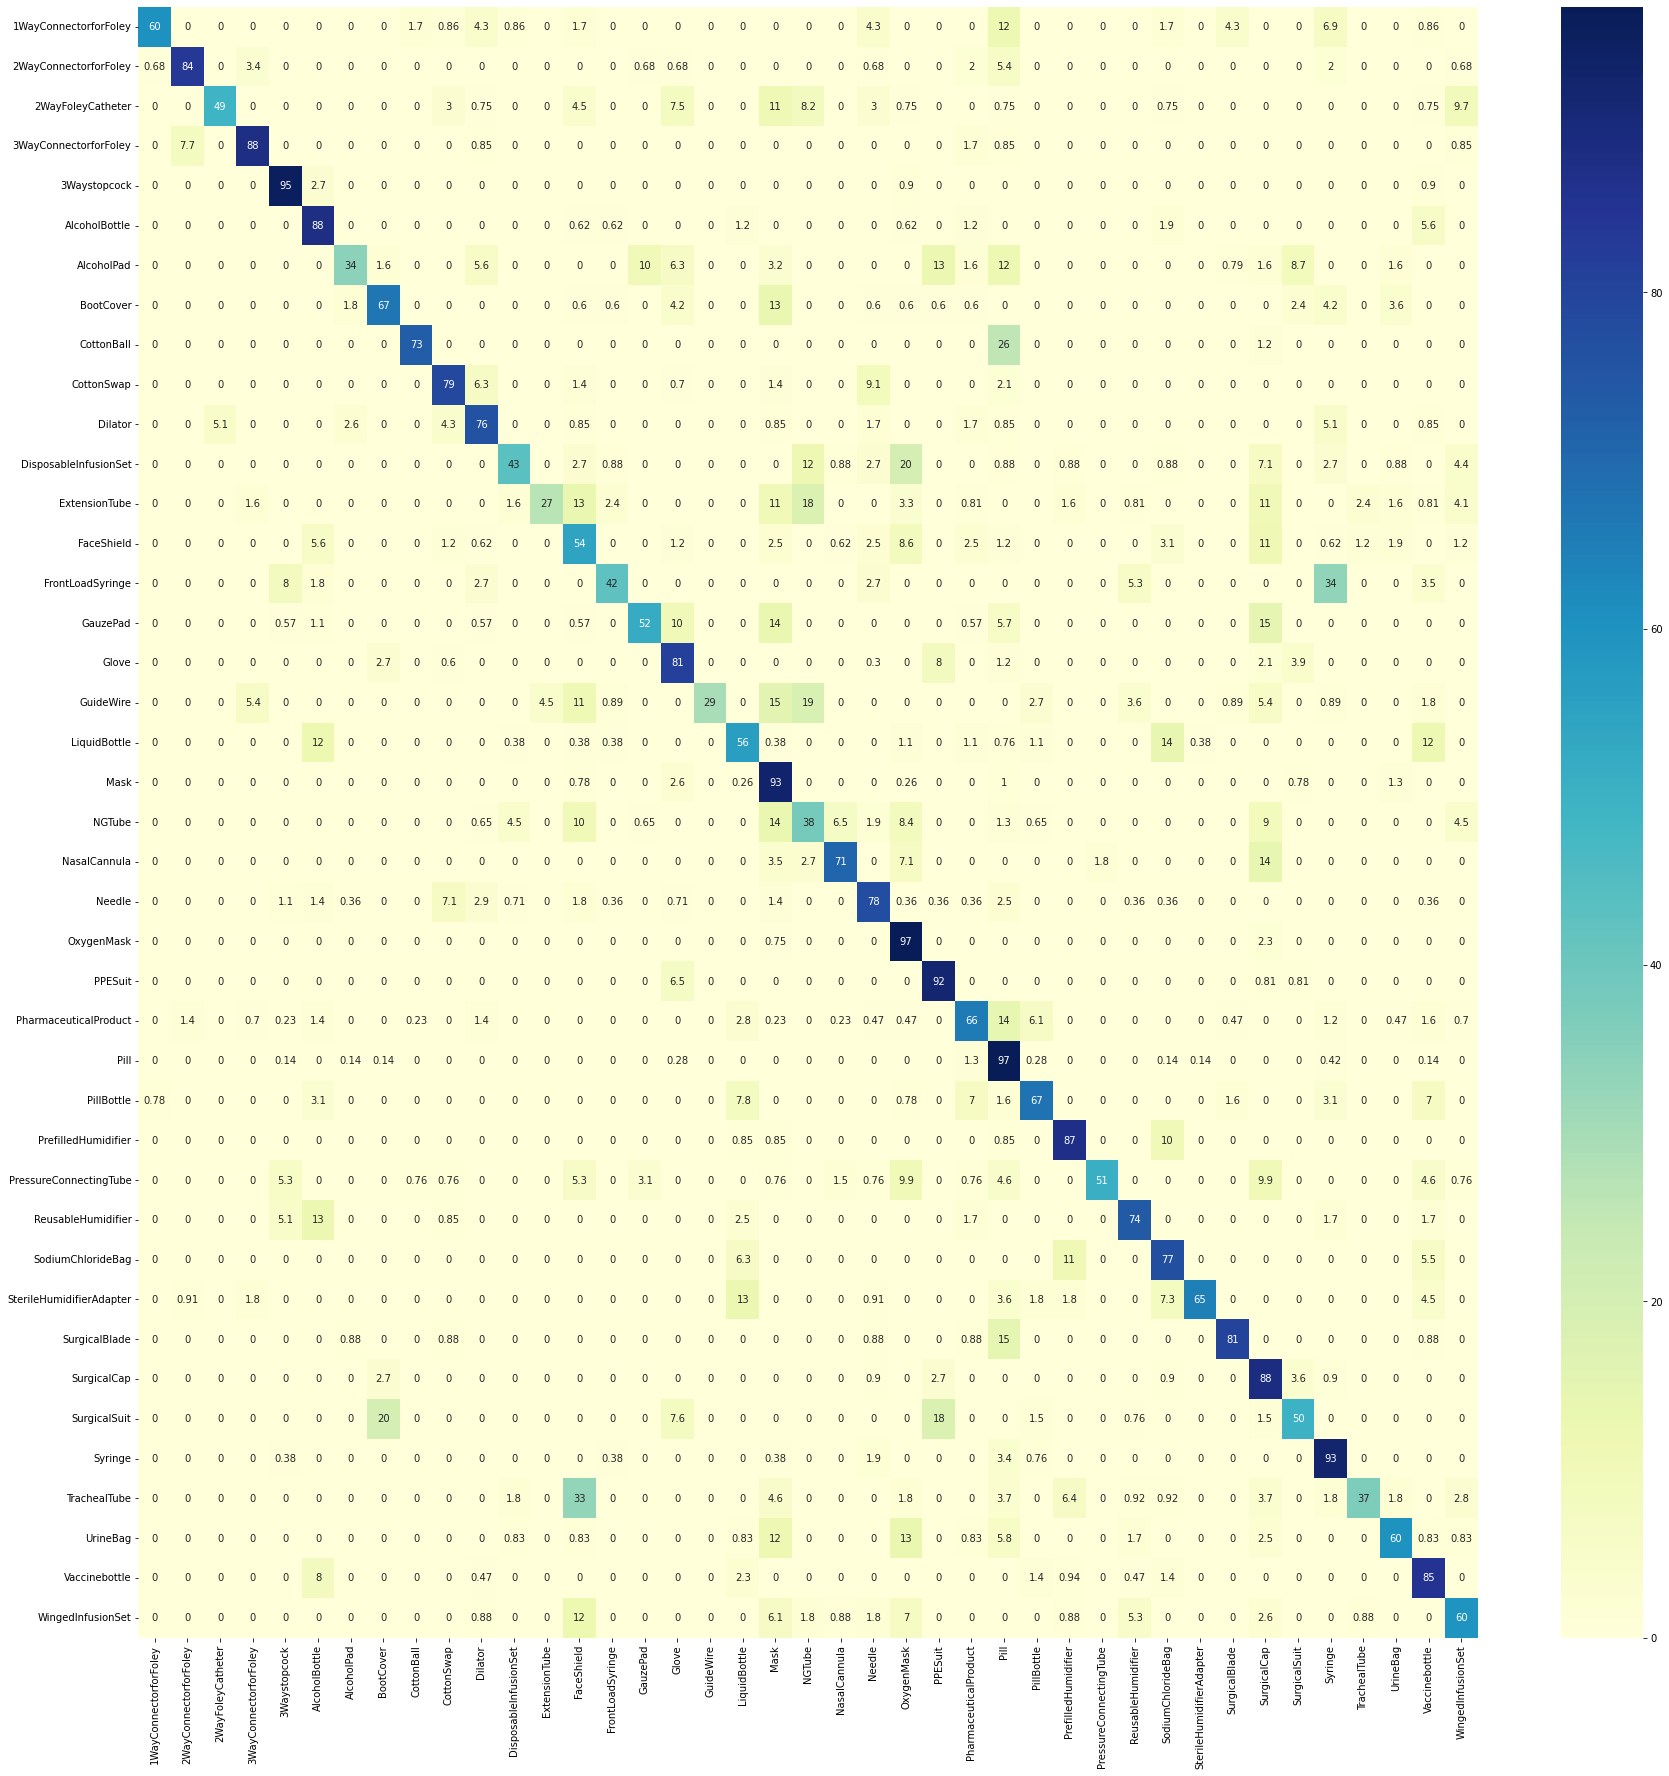

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")